In [94]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [148]:
class TimeSeriesData():
    
    def __init__(self,num_points,xmin,xmax):
        
        self.xmin = xmin
        self.xmax = xmax
        self.num_points = num_points
        #print('num_points: %f, xmin: %f, xmax: %f'%(num_points,xmin,xmax))
        self.resolution = float((xmax-xmin))/float(num_points)
        #print('resultion is %f:'%self.resolution)
        self.x_data = np.linspace(xmin,xmax,num_points)
        self.y_true = np.sin(self.x_data)
        
    def ret_true(self,x_series):
        return np.sin(x_series)
    
    def next_batch(self,batch_size,steps,return_batch_ts=False):
        # Grab a random starting point for each batch of data
        rand_start = np.random.rand(batch_size,1)
        
        # Conver to be on time series
        ts_start = rand_start*(self.xmax-self.xmin - (steps*self.resolution))
        #print(ts_start)  
        # Creat bathc time serioes on the x axis
        batch_ts  = ts_start + np.arange(0.0, steps+1) * self.resolution
        #print(batch_ts)
        
        y_batch = np.sin(batch_ts)
        
        
        if return_batch_ts:
            return y_batch[:,:-1].reshape(-1,steps,1), y_batch[:,1:].reshape(-1,steps,1), batch_ts
        else:
            return y_batch[:,:-1].reshape(-1,steps,1), y_batch[:,1:].reshape(-1,steps,1)

In [149]:
ts_data = TimeSeriesData(250,0,10)

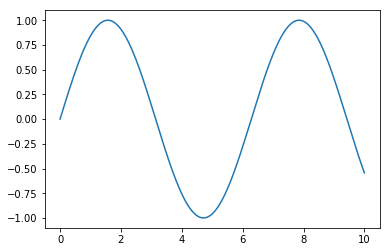

In [150]:
plt.plot(ts_data.x_data,ts_data.y_true)

In [151]:
ts_data.next_batch(1,3)

(array([[[-0.16356183],
         [-0.12398019],
         [-0.08420022]]]), array([[[-0.12398019],
         [-0.08420022],
         [-0.04428554]]]))

In [152]:
num_time_steps = 30
y1, y2, ts = ts_data.next_batch(1,num_time_steps,True)

In [153]:
y1

array([[[-0.79493249],
        [-0.81855807],
        [-0.84087414],
        [-0.86184498],
        [-0.88143706],
        [-0.89961903],
        [-0.9163618 ],
        [-0.93163858],
        [-0.94542494],
        [-0.95769883],
        [-0.9684406 ],
        [-0.97763307],
        [-0.98526154],
        [-0.99131379],
        [-0.99578016],
        [-0.9986535 ],
        [-0.9999292 ],
        [-0.99960522],
        [-0.99768209],
        [-0.99416289],
        [-0.98905323],
        [-0.9823613 ],
        [-0.9740978 ],
        [-0.96427595],
        [-0.95291147],
        [-0.94002253],
        [-0.92562976],
        [-0.90975618],
        [-0.89242718],
        [-0.87367048]]])

In [154]:
ts

array([[ 4.06048895,  4.10048895,  4.14048895,  4.18048895,  4.22048895,
         4.26048895,  4.30048895,  4.34048895,  4.38048895,  4.42048895,
         4.46048895,  4.50048895,  4.54048895,  4.58048895,  4.62048895,
         4.66048895,  4.70048895,  4.74048895,  4.78048895,  4.82048895,
         4.86048895,  4.90048895,  4.94048895,  4.98048895,  5.02048895,
         5.06048895,  5.10048895,  5.14048895,  5.18048895,  5.22048895,
         5.26048895]])

In [155]:
ts.shape

(1, 31)

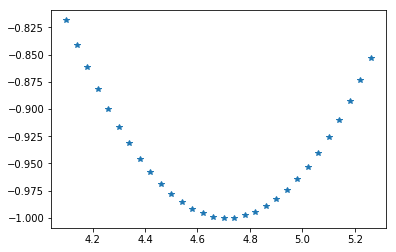

In [156]:
plt.plot(ts.flatten()[1:], y2.flatten(),'*')

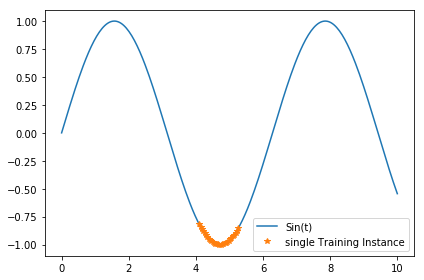

In [157]:
plt.plot(ts_data.x_data,ts_data.y_true,label='Sin(t)')
plt.plot(ts.flatten()[1:], y2.flatten(),'*', label="single Training Instance")
plt.legend()
plt.tight_layout()

In [158]:
# Training Data
train_inst = np.linspace(5,5+ts_data.resolution*(num_time_steps+1),num_time_steps+1)

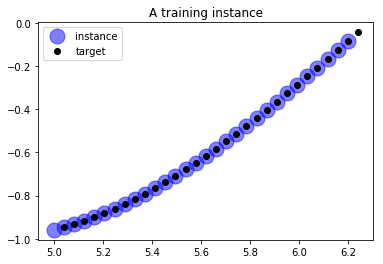

In [176]:
plt.title('A training instance')
plt.plot(train_inst[:-1],ts_data.ret_true(train_inst[:-1]),'bo', alpha=0.5,markersize=15,label='instance')

plt.plot(train_inst[1:],ts_data.ret_true(train_inst[1:]), 'ko',label='target')
plt.legend()

In [258]:
tf.reset_default_graph()

In [259]:
num_inputs = 1
num_neurons = 200
num_outputs = 1
learning_rate = 0.001
num_training_iteration = 2000
batch_size = 1

In [260]:
# PLACEHOLDERS
X = tf.placeholder(tf.float32,[None, num_time_steps,num_inputs])
y = tf.placeholder(tf.float32,[None, num_time_steps, num_outputs])

# RNN CELL LAYER
icell = tf.contrib.rnn.BasicLSTMCell(num_units=num_neurons, activation=tf.nn.relu)
cell = tf.contrib.rnn.OutputProjectionWrapper(icell,output_size=num_outputs)

In [261]:
outputs, states = tf.nn.dynamic_rnn(cell, X,dtype=tf.float32)

In [262]:
loss = tf.reduce_mean(tf.square(outputs-y))

In [263]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

In [264]:
train = optimizer.minimize(loss)

In [265]:
init = tf.global_variables_initializer()

In [266]:
saver = tf.train.Saver()

In [267]:
with tf.Session() as sess:
    sess.run(init)
    for iteration in range(num_training_iteration):
        X_batch, y_batch= ts_data.next_batch(batch_size,num_time_steps)
        sess.run(train,feed_dict={ X: X_batch,y:y_batch})
        
        if iteration % 100 == 0:
            
            mse = loss.eval(feed_dict={X:X_batch,y:y_batch})
            print(iteration,'\tMSE',mse)
    saver.save(sess,"./rnn_time_series_model")

(0, '\tMSE', 0.36642495)
(100, '\tMSE', 0.017026385)
(200, '\tMSE', 0.016438222)
(300, '\tMSE', 0.0027973114)
(400, '\tMSE', 0.015398095)
(500, '\tMSE', 0.00040992367)
(600, '\tMSE', 0.0012535942)
(700, '\tMSE', 0.0014481557)
(800, '\tMSE', 0.000811868)
(900, '\tMSE', 0.00017894139)
(1000, '\tMSE', 0.00011779824)
(1100, '\tMSE', 0.0026665437)
(1200, '\tMSE', 0.00012254631)
(1300, '\tMSE', 5.8315134e-05)
(1400, '\tMSE', 3.3505014e-05)
(1500, '\tMSE', 0.00016087103)
(1600, '\tMSE', 0.0010247711)
(1700, '\tMSE', 0.00021749377)
(1800, '\tMSE', 0.00016654149)
(1900, '\tMSE', 0.0020427345)


In [268]:
with tf.Session() as sess:
    saver.restore(sess, "./rnn_time_series_model")
    X_new = np.sin(np.array(train_inst[:-1].reshape(-1,num_time_steps,num_inputs)))
    y_pred = sess.run(outputs, feed_dict={X:X_new})

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model


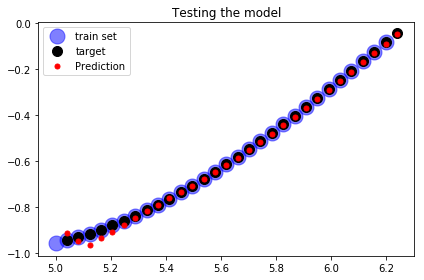

In [269]:
plt.title("Testing the model")

plt.plot(train_inst[:-1],np.sin(train_inst[:-1]),"bo",markersize=15,alpha=0.5, label="train set")
plt.plot(train_inst[1:],np.sin(train_inst[1:]), "ko", markersize = 10, label="target")
plt.plot(train_inst[1:],y_pred[0,:,0], 'r.', markersize=10,label='Prediction')
plt.legend()
plt.tight_layout()